In [22]:
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#modeling
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [23]:
#  Options 
pd.set_option("display.max_rows", 1091)

In [24]:
pickle_in = open("initially_cleaned_df.pkl","rb")
EDA = pickle.load(pickle_in)

/Users/hi/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/hi/anaconda3/envs/metis/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


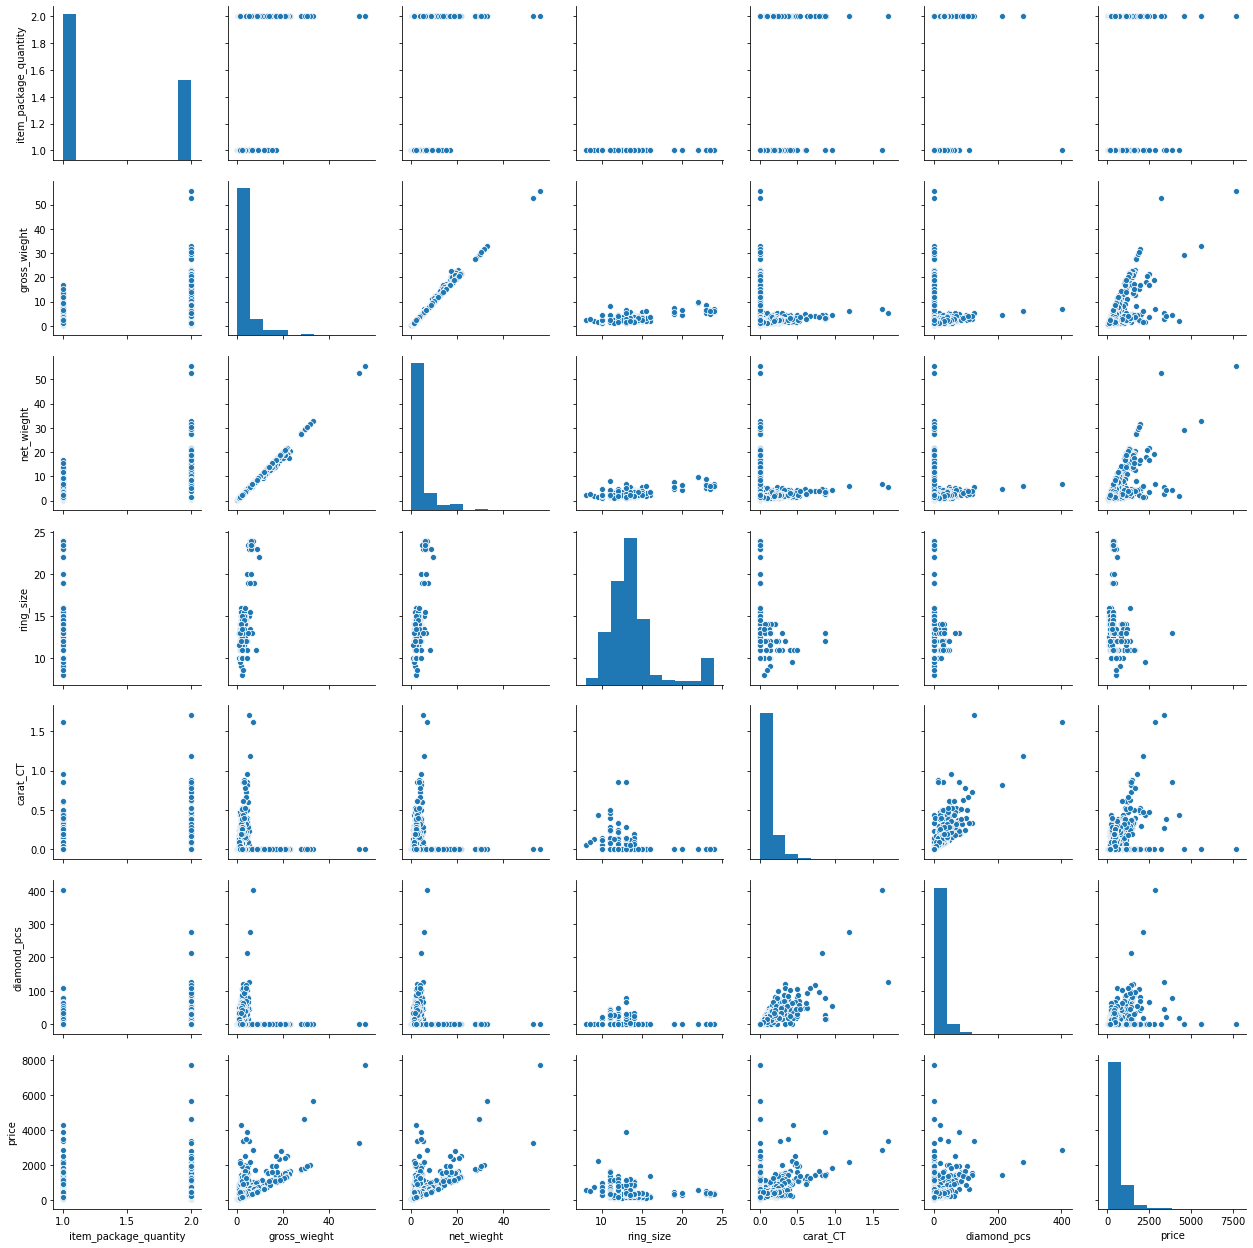

In [25]:
sns.pairplot(EDA)

(7, -0.7)

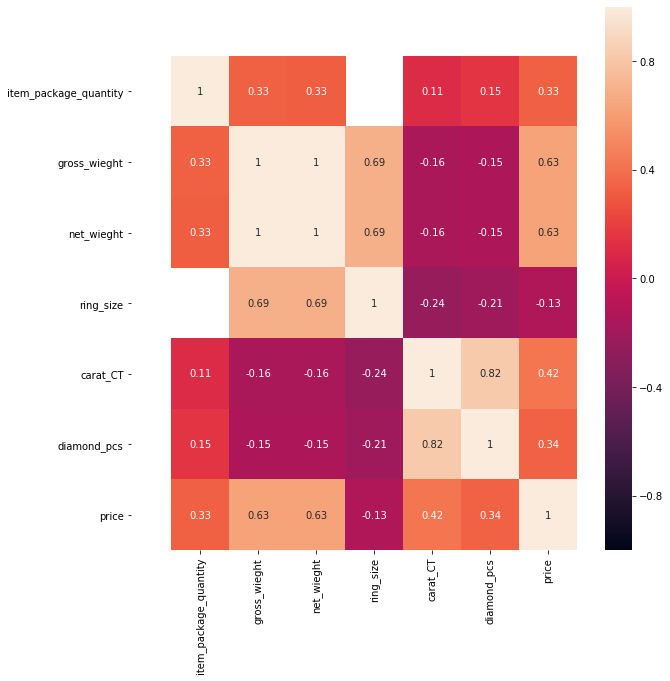

In [26]:
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(EDA.corr(), annot=True, vmin=-1, vmax=1, ax=ax );
plt.xlim(-0.7, 7)
plt.ylim(7,-0.7)

In [27]:
EDA.corr()

,item_package_quantity,gross_wieght,net_wieght,ring_size,carat_CT,diamond_pcs,price
item_package_quantity,1.000000,0.334583,0.326710,NaN,0.105265,0.150959,0.334058
gross_wieght,0.334583,1.000000,0.997559,0.692714,-0.163638,-0.147840,0.629950
net_wieght,0.326710,0.997559,1.000000,0.693924,-0.163520,-0.147821,0.632100
ring_size,NaN,0.692714,0.693924,1.000000,-0.244953,-0.209761,-0.134496
carat_CT,0.105265,-0.163638,-0.163520,-0.244953,1.000000,0.821811,0.422440
diamond_pcs,0.150959,-0.147840,-0.147821,-0.209761,0.821811,1.000000,0.342368
price,0.334058,0.629950,0.632100,-0.134496,0.422440,0.342368,1.000000


In [28]:
#split target column from features column 
target = EDA.loc[:, EDA.columns == 'price']
features = EDA.loc[:, ['item_package_quantity', 'gross_wieght', 'net_wieght',  'carat_CT', 'diamond_pcs']]


In [29]:
#Spliting for the baseline 
features_train, features_test, target_train, target_test = train_test_split(features,target, test_size=0.2, random_state=42)
features_train2, features_val, target_train2, target_val = train_test_split(features_train, target_train, test_size=.25, random_state=42)

# features_train.dropna(0, inplace=True)
# target_train.fillna(0, inplace=True)
# features_test.fillna(0, inplace=True)
baseline = LinearRegression()
baseline.fit(features_train,target_train)

print("Baseline Training score", baseline.score(features_train,target_train))
print("Baseline Test Score", baseline.score(features_test,target_test))



Baseline Training score 0.6719577143260773
Baseline Test Score 0.7244011657473277


In [30]:
#using kf to set consistent random_state+parameters across all runs
kf = KFold(n_splits=5, shuffle=True, random_state = 42)

#Lets also scale since we are using regularizstion
scaler = StandardScaler()
features_train2_scaled = scaler.fit_transform(features_train2)
features_val_scaled = scaler.transform(features_val)
features_test_scaled = scaler.transform(features_test)